In [4]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

I0000 00:00:1749023969.499543   32549 gpu_device.cc:2019] Created device /device:GPU:0 with 2735 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1749023969.501993   32549 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2735 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-06-04 15:59:29.569592: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 113100800 exceeds 10% of free system memory.
2025-06-04 15:59:29.655862: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 113100800 exceeds 10% of free system memory.
I0000 00:00:1749023970.619644   32549 cuda_dnn.cc:529] Loaded cuDNN version 90300


Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):


2025-06-04 15:59:31.013670: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 113100800 exceeds 10% of free system memory.
2025-06-04 15:59:31.075140: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 113100800 exceeds 10% of free system memory.
2025-06-04 15:59:31.152792: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 113100800 exceeds 10% of free system memory.


1.1434972509996442
GPU (s):
0.13189756500014482
GPU speedup over CPU: 8x


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
tf.__version__, hub.__version__

('2.19.0', '0.16.1')

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory
import os

DIR = "./dataset/images/Images"
labels = sorted(os.listdir(DIR))
print(labels)

BATCH_SIZE = 32
IMG_SHAPE = (224, 224)
train_data, test_data = image_dataset_from_directory(
    DIR,
    batch_size = BATCH_SIZE,
    image_size = IMG_SHAPE,
    label_mode = "categorical",
    validation_split = 0.2,
    subset = "both",
    seed = 42,
    shuffle=True
)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

In [14]:
len(train_data.class_names)

120

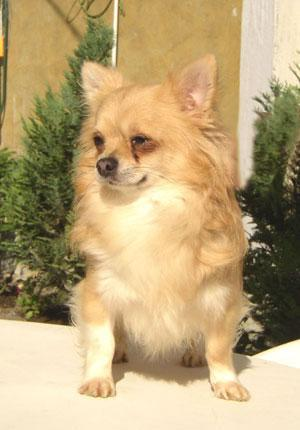

In [15]:
from IPython.display import Image
Image('dataset/images/Images/n02085620-Chihuahua/n02085620_199.jpg')

In [16]:
layer1 = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [25]:
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    Conv2D,
    MaxPool2D,
    RandomHeight,
    RandomWidth,
    RandomZoom,
    RandomRotation,
    RandomFlip,
)
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
layer1 = tf.keras.applications.MobileNetV2(include_top=False, input_shape=IMG_SHAPE + (3,))
layer1.trainable = False
model = tf.keras.Sequential([
    layer1,
    GlobalAveragePooling2D(),
    Dense(120, activation="softmax")
])

#NORMAL WAY

# model = tf.keras.Sequential([
#     Conv2D(256, 5, activation="relu", input_shape = IMG_SHAPE + (3,)),
#     Conv2D(256, 5, activation="relu"),
#     MaxPool2D(),
#     Conv2D(128, 5, activation="relu"),
#     Conv2D(128, 5, activation="relu"),
#     MaxPool2D(),
#     Conv2D(64, 5, activation="relu"),
#     Conv2D(64, 5, activation="relu"),
#     MaxPool2D(),
#     Flatten(),
#     Dense(120, activation="softmax"),
# ])

# EFFICIENTNET 
#tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
import matplotlib.pyplot as plt
def plot_history_graph(history_feature_extraction):
    accuracy = history_feature_extraction.history["accuracy"]
    val_accuracy = history_feature_extraction.history["val_accuracy"]

    loss = history_feature_extraction.history["loss"]
    val_loss = history_feature_extraction.history["val_loss"]

    epoch = history_feature_extraction.epoch

    figure = plt.figure(figsize=(10, 5))
    plt.plot(epoch, accuracy, label="training accuracy")
    plt.plot(epoch, val_accuracy, label="testing accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("accuracy graph")
    plt.legend()

    figure2 = plt.figure(figsize=(10, 5))
    plt.plot(epoch, loss, label="training loss")
    plt.plot(epoch, val_loss, label="testing  loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("loss curve")
    plt.legend()

    plt.show()

In [27]:
import datetime


def tensorboard_callback():
    logdir = os.path.join(
        "drive/My Drive/Data/logs",
        # Make it so the logs get tracked whenever we run an experiment
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    )
    return tf.keras.callbacks.TensorBoard(logdir)


tb = tensorboard_callback()
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
history_feature_extraction = model.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    validation_freq=1,
    callbacks=[tb, early_stop],
)


Epoch 1/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.1062 - loss: 4.0895 - val_accuracy: 0.0658 - val_loss: 4.5142
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.1413 - loss: 3.8920 - val_accuracy: 0.0646 - val_loss: 4.4994
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.1693 - loss: 3.7307 - val_accuracy: 0.0688 - val_loss: 4.4676
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.1975 - loss: 3.6010 - val_accuracy: 0.0787 - val_loss: 4.4835
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.2123 - loss: 3.4895 - val_accuracy: 0.0794 - val_loss: 4.4536
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.2400 - loss: 3.3726 - val_accuracy: 0.0804 - val_loss: 4.4638
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.2537 - loss: 3.2952 - val_accuracy: 0.0792 - val_loss: 4.4778
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - accuracy: 0.2703 - loss: 3

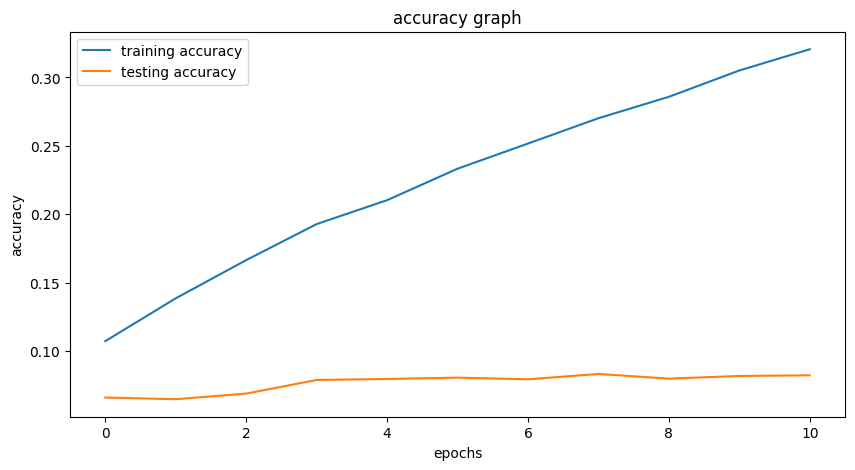

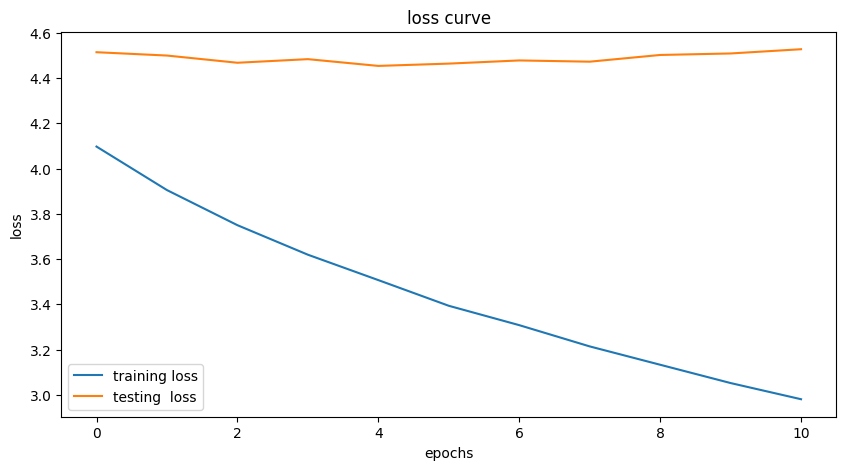

In [28]:
plot_history_graph(history_feature_extraction)

In [29]:
model.evaluate(test_data)

129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.0816 - loss: 4.5632


[4.52738094329834, 0.08211856335401535]

In [63]:
# %tensorboard --logdir /kaggle/working/logs         ##Does not work on kaggle

In [64]:
predictions = model.predict(val_data,verbose=1)
predictions

7/7 [==============================] - 1s 41ms/step


array([[1.55146664e-03, 7.24499971e-02, 2.10514554e-04, ...,
        3.66865599e-04, 1.72962854e-03, 4.52118507e-03],
       [1.72575878e-03, 5.40387467e-04, 4.52381733e-04, ...,
        8.56560539e-04, 3.20603931e-03, 4.93327342e-03],
       [4.65574558e-05, 8.29054698e-05, 3.38550715e-04, ...,
        8.30248289e-04, 4.40218864e-04, 1.44268151e-05],
       ...,
       [3.65254964e-04, 1.16142510e-04, 1.40649630e-04, ...,
        1.11136837e-02, 6.82908239e-06, 2.13096049e-04],
       [1.00016565e-04, 9.38822559e-05, 1.30857120e-03, ...,
        1.17243989e-03, 2.49455392e-04, 4.58449271e-04],
       [2.46505188e-05, 8.81439846e-05, 5.20032427e-06, ...,
        4.66615966e-05, 2.41647824e-04, 3.38355452e-03]], dtype=float32)

In [65]:
predictions.shape

(200, 120)

In [66]:
idx=0
print(predictions[idx])
print(f"Max value is: {np.max(predictions[idx])}")
print(f"index of max value is: {np.argmax(predictions[idx])}")
print(f"predicted breed is {unique_breeds[np.argmax(predictions[idx])]}")
# print(f"actual breed is {})

[1.55146664e-03 7.24499971e-02 2.10514554e-04 1.29095512e-03
 1.02794031e-04 9.09505645e-04 6.84477738e-04 5.53631282e-04
 5.33019518e-03 7.95313099e-05 3.29909776e-03 5.80598076e-04
 1.16931053e-03 2.64108239e-04 7.63951102e-03 3.39076412e-03
 4.30002459e-04 9.42696715e-05 1.28080917e-03 2.23641400e-04
 1.53655489e-03 1.06244450e-04 6.58813515e-05 4.64421045e-03
 6.53313997e-04 4.25579899e-04 9.29157541e-04 1.17096608e-03
 3.43179825e-04 4.90771374e-04 8.94225319e-04 6.94960123e-03
 4.55035921e-03 7.85280135e-04 6.44399028e-04 7.95155391e-03
 1.95420711e-04 1.59537757e-03 1.70347092e-04 4.46562510e-04
 3.25466593e-04 1.52821245e-04 2.72548961e-04 2.66019162e-03
 2.56976904e-03 2.03755932e-04 5.57355001e-04 1.22394203e-03
 4.26550425e-04 1.02013978e-03 9.24090913e-04 4.37427050e-04
 1.56858680e-03 2.65321904e-03 1.33560097e-03 1.68866129e-03
 1.10725733e-03 8.81852757e-04 6.90953434e-02 1.44007464e-03
 1.57523231e-04 1.48480712e-03 9.67613130e-04 9.03042906e-04
 1.02885730e-04 5.398083

In [67]:
def get_y_val(index):
    return unique_breeds[np.argmax(predictions[index])]

In [68]:
get_y_val(0)

'komondor'

In [69]:
def unbatchify(data):
    images=[]
    labels=[]
    
    for image,label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return images,labels
    

In [70]:
val_img,val_label=unbatchify(val_data)
val_label

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [71]:
def plot_pred(index):
    y_val=get_y_val(index)
    y_actual=unique_breeds[np.argmax(val_label[index])]
    img=val_img[index]
    y_prob=np.max(predictions[index])
    
    plt.imshow(img)
    plt.axis("off")
    
    if y_val==y_actual:
        color="green"
    else:
        color="red"
            
    plt.title(f"{y_val} {(y_prob*100):.2f}% ({y_actual})",color=color)
    

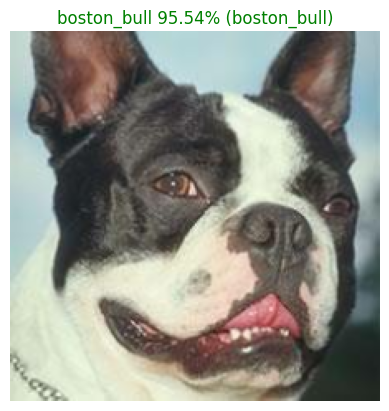

In [72]:
plot_pred(13)

In [73]:
get_y_val(1)

'papillon'

In [74]:
val_label[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [75]:
!ls

__notebook__.ipynb  drive  logs


In [76]:
def save_model(model,suffix=None):
    modeldir=os.path.join("models",datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    
    model_path=modeldir+"-"+suffix+".h5"
    print(f"saving to {model_path}")
    
    model.save(model_path)
    return model_path

def load_model(model_path):
    print(f"loading from {model_path}")
    
    model=tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
    
    return model

In [77]:
# save_model(model,"1000-mobilenetV2-Adam")
model.save("models/1000-mobilenetV2-Adam.h5", overwrite=True)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [78]:
yoyo=load_model("/kaggle/working/models/1000-mobilenetV2-Adam.h5")

loading from /kaggle/working/models/1000-mobilenetV2-Adam.h5


In [79]:
yoyo.evaluate(val_data)

7/7 [==============================] - 1s 50ms/step - loss: 1.1890 - accuracy: 0.6550


[1.1889532804489136, 0.6549999713897705]

In [80]:
len(X)

10222

In [81]:
len(y)

10222

In [82]:
full_data=create_batch(X,y)
full_data


Creating train batches


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [83]:
full_model=create_model()

Building model with  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [84]:
full_model_tb=tensorboard_callback()
full_model_stop=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=5)

In [85]:
full_model.fit(x=full_data,epochs=NUM_EPOCHS,callbacks=[full_model_tb,full_model_stop])

Epoch 1/100
320/320 [==============================] - 29s 79ms/step - loss: 1.3353 - accuracy: 0.6714
Epoch 2/100
320/320 [==============================] - 15s 46ms/step - loss: 0.4023 - accuracy: 0.8824
Epoch 3/100
320/320 [==============================] - 15s 46ms/step - loss: 0.2351 - accuracy: 0.9382
Epoch 4/100
320/320 [==============================] - 15s 47ms/step - loss: 0.1521 - accuracy: 0.9641
Epoch 5/100
320/320 [==============================] - 15s 47ms/step - loss: 0.1060 - accuracy: 0.9788
Epoch 6/100
320/320 [==============================] - 15s 47ms/step - loss: 0.0779 - accuracy: 0.9857
Epoch 7/100
320/320 [==============================] - 15s 47ms/step - loss: 0.0584 - accuracy: 0.9918
Epoch 8/100
320/320 [==============================] - 15s 47ms/step - loss: 0.0460 - accuracy: 0.9939
Epoch 9/100
320/320 [==============================] - 15s 46ms/step - loss: 0.0359 - accuracy: 0.9973
Epoch 10/100
320/320 [==============================] - 15s 47ms/step - l

In [86]:
# save_model(full_model,"full_trained-mobilenetV2-Adam")
full_model.save("models/full_trained_mobilenetV2-Adam.h5", overwrite=True)

In [87]:
test_path="/kaggle/input/dog-breed-identification/test/"
test_file=[test_path + fname for fname in os.listdir(test_path)]

In [88]:
test_file[:10]

['/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg',
 '/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg',
 '/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg',
 '/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg',
 '/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg',
 '/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg',
 '/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg',
 '/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg',
 '/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg',
 '/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg']

In [89]:
len(test_file)

10357

In [90]:
test_data=create_batch(test_file,test_data=True)

Creating test batches...


In [91]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [92]:
test_predictions=full_model.predict(test_data,verbose=1)

324/324 [==============================] - 27s 83ms/step


In [93]:
test_predictions[:10]

array([[4.16365423e-12, 9.57152906e-15, 1.14381116e-10, ...,
        1.05384238e-07, 1.40529645e-11, 9.53179619e-11],
       [1.77885770e-15, 1.24669677e-10, 4.15711616e-15, ...,
        9.06012210e-10, 3.43179024e-14, 5.94823254e-15],
       [1.85958835e-11, 9.55030282e-06, 5.37915490e-10, ...,
        2.01871337e-08, 1.20745306e-13, 2.97703973e-13],
       ...,
       [1.60942371e-09, 2.37004216e-09, 5.38059289e-13, ...,
        2.51277221e-10, 1.29059556e-14, 1.50347247e-14],
       [1.43419275e-05, 6.22214529e-08, 1.06065306e-06, ...,
        2.08310418e-08, 1.29744660e-06, 1.95109635e-08],
       [1.70877712e-09, 1.23964228e-09, 3.83196287e-11, ...,
        1.38077480e-10, 1.09379363e-11, 1.24594631e-11]], dtype=float32)

In [94]:
test_predictions.shape

(10357, 120)

In [95]:
import pandas as pd
preds_df=pd.DataFrame(columns=["id"]+list(unique_breeds))
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [96]:
test_ids=[fname[:-4] for fname in os.listdir("/kaggle/input/dog-breed-identification/test")]
# test_ids=[fname[:-4] for fname in test_ids]

In [97]:
test_ids[:10]

['09e51e17e2b756ff2ace8a87bd1443fa',
 'f7a32505c12649183c5991ecfa7d68b3',
 'bc6d50ffb4644feb34530aa58943e85b',
 '7cbc041e79135a572aad87904b5c9c57',
 'f3b603f10d6a344f0395fb46b242ff8e',
 'db55098d859d27a3c05b0e3fc41d43e7',
 '665bab06a3ea861c0812c778486988e3',
 '7b57911ea7559cebd6db308125926642',
 'df0d6ba158287cb2b3ed6459a22d42ba',
 'b80d89ad4a17ac2537ff46d251efcd7c']

In [98]:
preds_df["id"]=test_ids
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f7a32505c12649183c5991ecfa7d68b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bc6d50ffb4644feb34530aa58943e85b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7cbc041e79135a572aad87904b5c9c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f3b603f10d6a344f0395fb46b242ff8e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
preds_df[list(unique_breeds)]=test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,4.163654e-12,9.571529e-15,1.143811e-10,1.708189e-10,3.510282e-02,2.935615e-13,2.346152e-09,8.546505e-09,1.047142e-12,...,1.598260e-09,3.489457e-08,1.013594e-10,5.447708e-10,1.375137e-13,5.532396e-15,6.388969e-10,1.053842e-07,1.405296e-11,9.531796e-11
1,f7a32505c12649183c5991ecfa7d68b3,1.778858e-15,1.246697e-10,4.157116e-15,2.554902e-13,4.577864e-11,2.292269e-11,6.419466e-11,1.004115e-10,2.042282e-10,...,6.541679e-13,1.224876e-13,1.495553e-07,1.191131e-08,3.285399e-13,1.700984e-13,1.263957e-15,9.060122e-10,3.431790e-14,5.948233e-15
2,bc6d50ffb4644feb34530aa58943e85b,1.859588e-11,9.550303e-06,5.379155e-10,2.191585e-08,4.713842e-09,9.770419e-11,6.337052e-12,2.370310e-12,2.736030e-10,...,3.476031e-11,1.359773e-13,6.858712e-14,3.966893e-10,3.262506e-09,2.635860e-10,1.688232e-14,2.018713e-08,1.207453e-13,2.977040e-13
3,7cbc041e79135a572aad87904b5c9c57,2.362018e-11,6.738064e-14,9.026312e-15,6.541695e-12,4.006142e-08,1.441822e-08,2.058963e-11,5.785404e-12,2.768214e-14,...,2.706244e-11,6.112068e-10,4.450621e-12,8.802120e-13,2.200264e-05,2.844256e-15,2.190448e-13,2.126822e-06,1.416438e-10,7.831415e-12
4,f3b603f10d6a344f0395fb46b242ff8e,1.584740e-15,1.242910e-14,6.279446e-15,2.434761e-11,9.948958e-15,1.140895e-11,4.520154e-12,1.554902e-13,4.271370e-11,...,2.217179e-15,7.304017e-14,5.847693e-13,1.251529e-13,4.650599e-16,9.999977e-01,6.212165e-14,3.222434e-15,1.175341e-14,5.641220e-15


In [100]:
preds_df.to_csv("submission.csv",index=False)

In [101]:
preds_df.shape

(10357, 121)